In [1]:
import json
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model.to(device)

with open("./imagenet_class_idx.json", "r") as f:
    classes = json.load(f)

/home/guest-one/Yash/inverse_cnns/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:184: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from torchvision import transforms
from PIL import Image

img_path = "./imagenet-sample-images/n01443537_goldfish.JPEG"
image = Image.open(img_path).convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
input_tensor = preprocess(image).unsqueeze(0).to(device)

# Pass tensor into the resnet
with torch.no_grad():
    output = model(input_tensor)

In [3]:
classes[torch.argmax(output, dim=1)]

'goldfish, Carassius auratus'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.2146587].


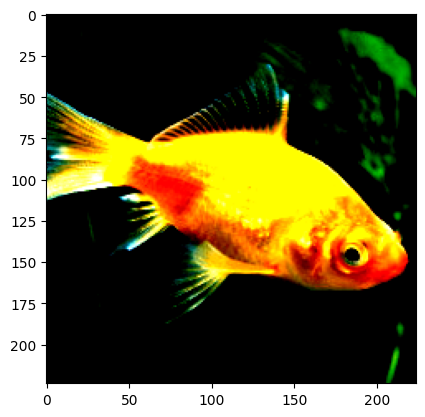

In [4]:
import matplotlib.pyplot as plt

plt.imshow(input_tensor.squeeze().numpy().transpose(1, 2, 0))

In [5]:
batch_size = 16
batch_shape = torch.stack([input_tensor.squeeze()] * batch_size).shape
random_batch = torch.randn(batch_shape, requires_grad=True)
random_batch.shape

torch.Size([16, 3, 224, 224])

In [6]:
num_steps = 30
optimizer = torch.optim.Adam([random_batch], lr=0.01)
criterion = nn.CrossEntropyLoss()

model.requires_grad = False

In [7]:
desired_prediciton = "goldfish, Carassius auratus"
desired_prediction_idx = classes.index(desired_prediciton)
target = torch.Tensor([desired_prediction_idx] * batch_size).to(device).long()

In [8]:
for step in range(num_steps):
    optimizer.zero_grad()

    output = model(random_batch)

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step} loss: {loss.item()}")


Step 0 loss: 5.671894550323486


Step 10 loss: 0.024000344797968864
Step 20 loss: 0.0028443930204957724


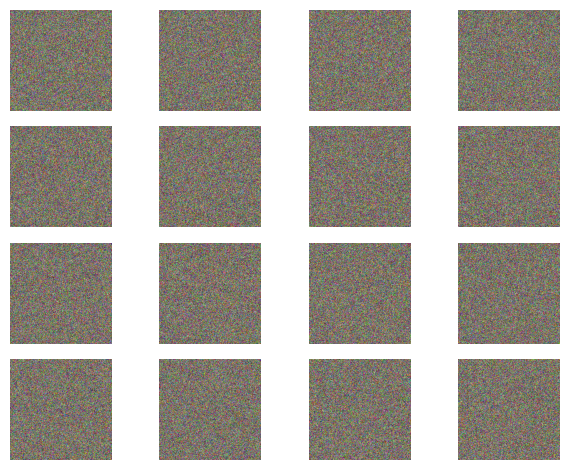

In [9]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i in range(0, 16):
    plt.subplot(4, 4, i + 1)
    img = random_batch[i].squeeze().detach() * std + mean
    img = img.clamp(0, 1)
    plt.imshow(img.numpy().transpose(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
from torch.nn.functional import softmax

model_out = model(random_batch)
class_probs = softmax(model_out, dim=1)

print("Class probabilities:")
print(class_probs[:, desired_prediction_idx])

Class probabilities:
tensor([0.9987, 0.9991, 0.9988, 0.9988, 0.9986, 0.9989, 0.9979, 0.9990, 0.9992,
        0.9990, 0.9990, 0.9984, 0.9992, 0.9990, 0.9990, 0.9988],
       grad_fn=<SelectBackward0>)


## Adversarial Image Manipulation

In [11]:
import os
import random
from torch.nn.functional import mse_loss

batch_size = 16
image_paths = random.sample(os.listdir("./imagenet-sample-images"), batch_size)
images = [
    Image.open(os.path.join("./imagenet-sample-images", img_path)).convert("RGB")
    for img_path in image_paths
]

image_labels = ["_".join(path.split("_")[1:]).split(".")[0] for path in image_paths]

In [12]:
target = torch.Tensor([desired_prediction_idx] * batch_size).to(device).long()

preprocessed_images = [preprocess(image) for image in images]
starting_images = torch.stack(preprocessed_images)
starting_images.requires_grad = False

current_images = starting_images.clone().detach()
current_images.requires_grad = True

optimizer = torch.optim.Adam([current_images], lr=0.01)

criterion = nn.CrossEntropyLoss()

In [13]:
original_predictions = model(starting_images)
original_label_idxs = torch.argmax(original_predictions, dim=1)
original_labels = [classes[idx] for idx in original_label_idxs]
original_probs = softmax(original_predictions, dim=1)[torch.arange(batch_size), original_label_idxs]

In [14]:
num_steps = 30

alpha = 0.5
for step in range(num_steps):
    optimizer.zero_grad()

    output = model(current_images)

    label_loss = criterion(output, target)
    similarity_loss = mse_loss(current_images, starting_images)

    loss = alpha * label_loss + (1 - alpha) * similarity_loss
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step} loss: {loss.item()}")

Step 0 loss: 8.871529579162598
Step 10 loss: 0.008591406978666782


Step 20 loss: 0.0029380079358816147


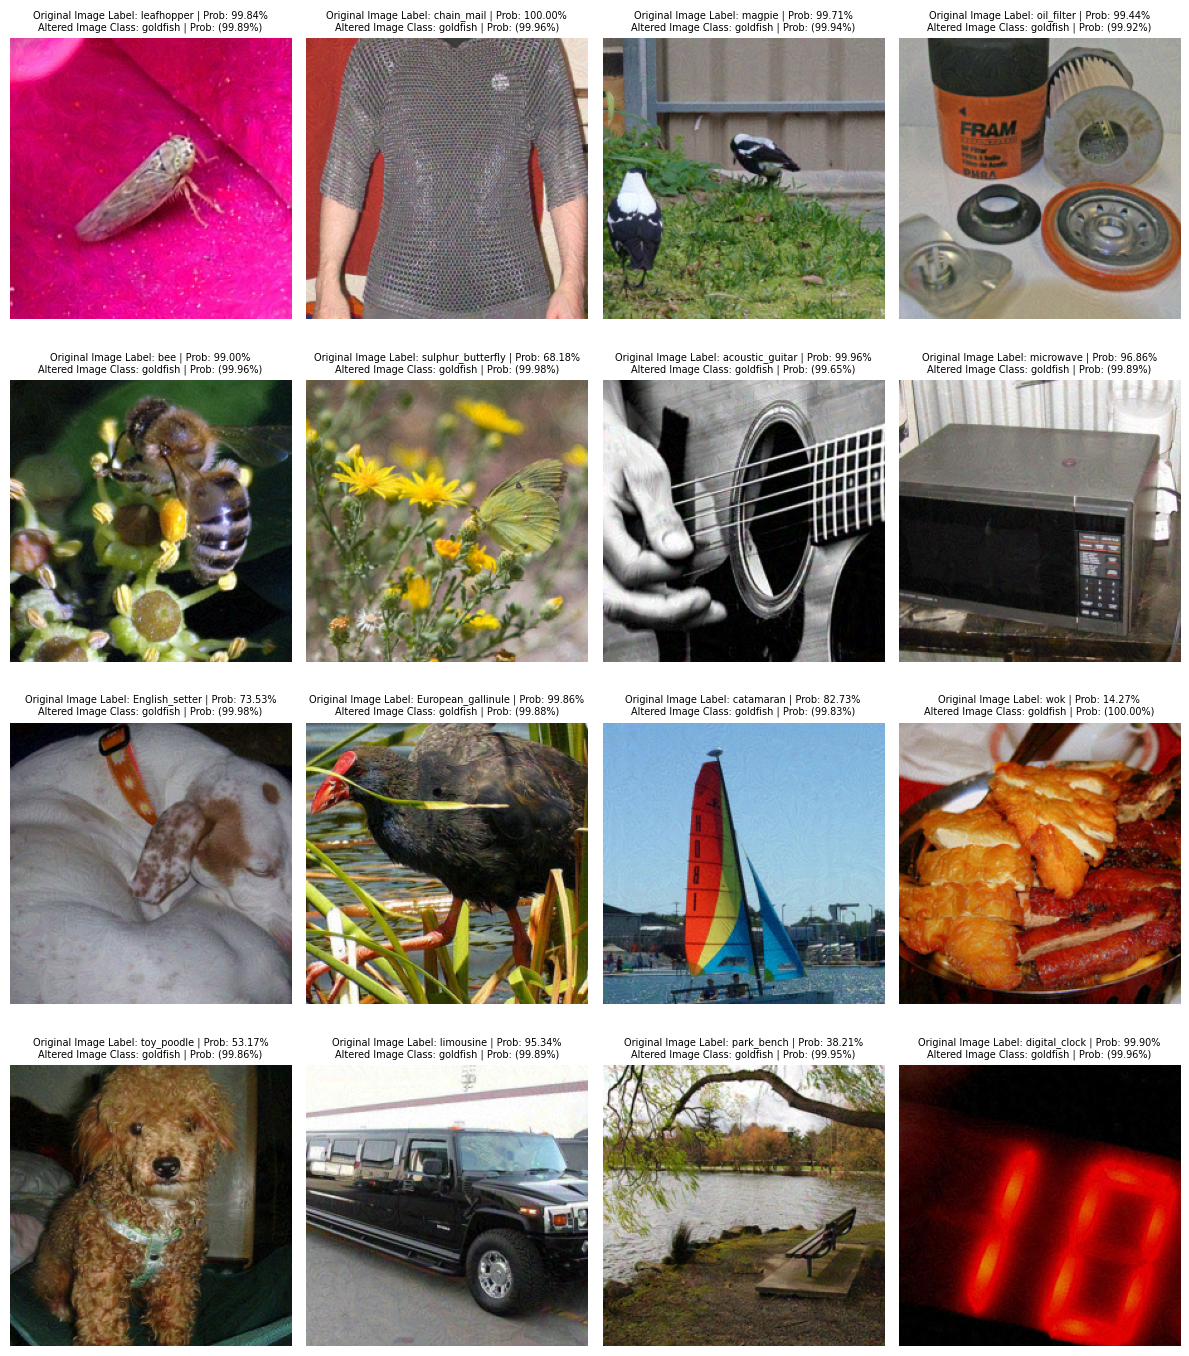

In [ ]:
with torch.no_grad():
    output = model(current_images)
    probs = softmax(output, dim=1)

predicted_idxs = torch.argmax(output, dim=1)
predicted_probs = probs[torch.arange(batch_size), predicted_idxs]
goldfish_probs = probs[:, desired_prediction_idx]

def find_class_idx(label):
    label_lower = label.lower().replace("_", " ")
    for idx, class_name in enumerate(classes):
        if label_lower in class_name.lower():
            return idx
    return None

original_class_idxs = [find_class_idx(label) for label in image_labels]

fig, axes = plt.subplots(4, 4, figsize=(12, 14))
for i in range(0, 16):
    ax = axes[i // 4, i % 4]
    img = current_images[i].squeeze().detach() * std + mean
    img = img.clamp(0, 1)

    orig_label = image_labels[i]
    pred_class = classes[predicted_idxs[i].item()].split(",")[0]  # Short name

    orig_prob = original_probs[i].item()

    title = f"Original Image Label: {orig_label} | Prob: {orig_prob:.2%}\nAltered Image Class: {pred_class} | Prob: ({predicted_probs[i]:.2%})"

    ax.set_title(title, fontsize=7)
    ax.imshow(img.numpy().transpose(1, 2, 0))
    ax.axis("off")
plt.tight_layout()
plt.show()

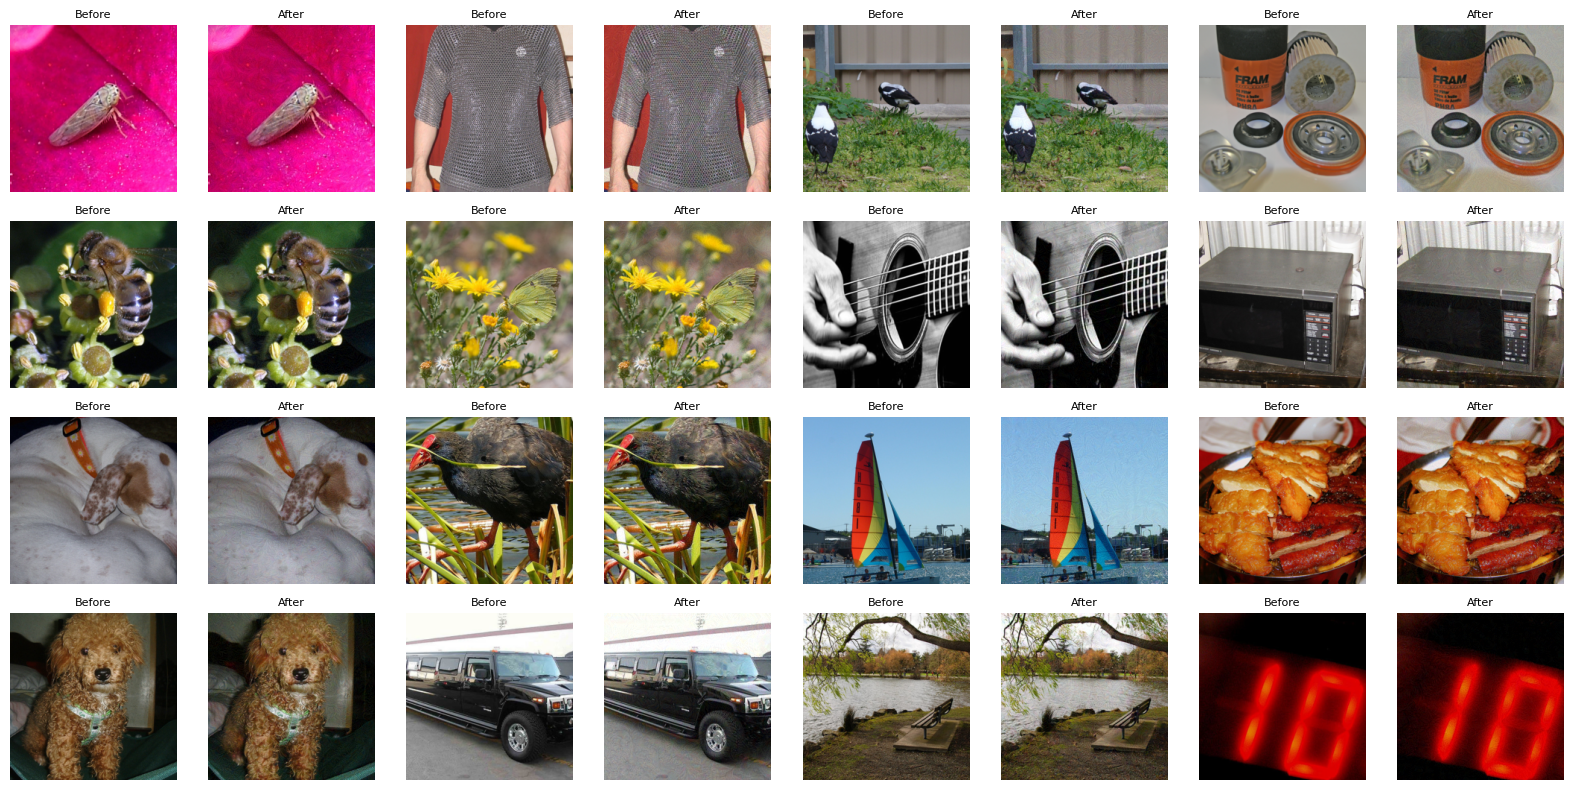

In [16]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i in range(16):
    row = i // 4
    col = (i % 4) * 2

    # Before
    img_before = (starting_images[i].squeeze().detach() * std + mean).clamp(0, 1)
    axes[row, col].imshow(img_before.numpy().transpose(1, 2, 0))
    axes[row, col].set_title('Before', fontsize=8)
    axes[row, col].axis('off')

    # After
    img_after = (current_images[i].squeeze().detach() * std + mean).clamp(0, 1)
    axes[row, col + 1].imshow(img_after.numpy().transpose(1, 2, 0))
    axes[row, col + 1].set_title('After', fontsize=8)
    axes[row, col + 1].axis('off')

plt.tight_layout()
plt.show()
